# Time Series Analysis

**Contents**

1. Data ETL | Processing
2. Modeling
3. Evaluation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from darts.timeseries import TimeSeries

from components import config
from components.ts_logger import logger
from components.utils import get_csv_dataframe

2024-01-26 07:27:38 [info     ] logger initialized


## 1. Data ETL | Processing

- Parse CSV Data
- Missing Values ?
- Stationarity ?

### Parse CSV Data

In [2]:
dataset_path = config.io_paths["DATASET"]
index_column = "DateTime"
datetime_format = config.DATETIME_FORMAT

df = get_csv_dataframe(dataset_path, index_column, datetime_format)
df_load = df[["Consumption"]] #len : 36772
df_load = df_load.resample('H').mean()

logger.info(">> dataset imported")
df_load.info()

2024-01-26 07:27:40 [info     ] >> dataset imported
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 36768 entries, 2019-01-01 00:00:00 to 2023-03-12 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Consumption  36764 non-null  float64
dtypes: float64(1)
memory usage: 574.5 KB


### Missing Values (?)

- imputation : constant value imputation, mean, median or mode imputation, and forward-fill or backward-fill.
- interpolation : use mathematical functions to estimate missing values based on the values of the surrounding observations, e.g. `linear interpolation, polynomial interpolation, and spline interpolation`
- predictive modeling : build ml models to predict missing values, e.g. knn, regression, dts, random forest.

In [3]:
logger.info(">> checking missing values")
logger.info(">> missing values: {}".format(df_load.isnull().sum()))
logger.info(">> interpolating missing values")
df_load = df_load.interpolate()
print("missing values: ", df_load.isnull().sum())
print("dataset shape: ", df_load.shape)

2024-01-26 07:27:41 [info     ] >> checking missing values
2024-01-26 07:27:41 [info     ] >> missing values: Consumption    4
dtype: int64
2024-01-26 07:27:41 [info     ] >> interpolating missing values
missing values:  Consumption    0
dtype: int64
dataset shape:  (36768, 1)


### Stationarity ?



2024-01-26 07:27:42 [info     ] >> decomposition plot of trend, seasonality,and residual


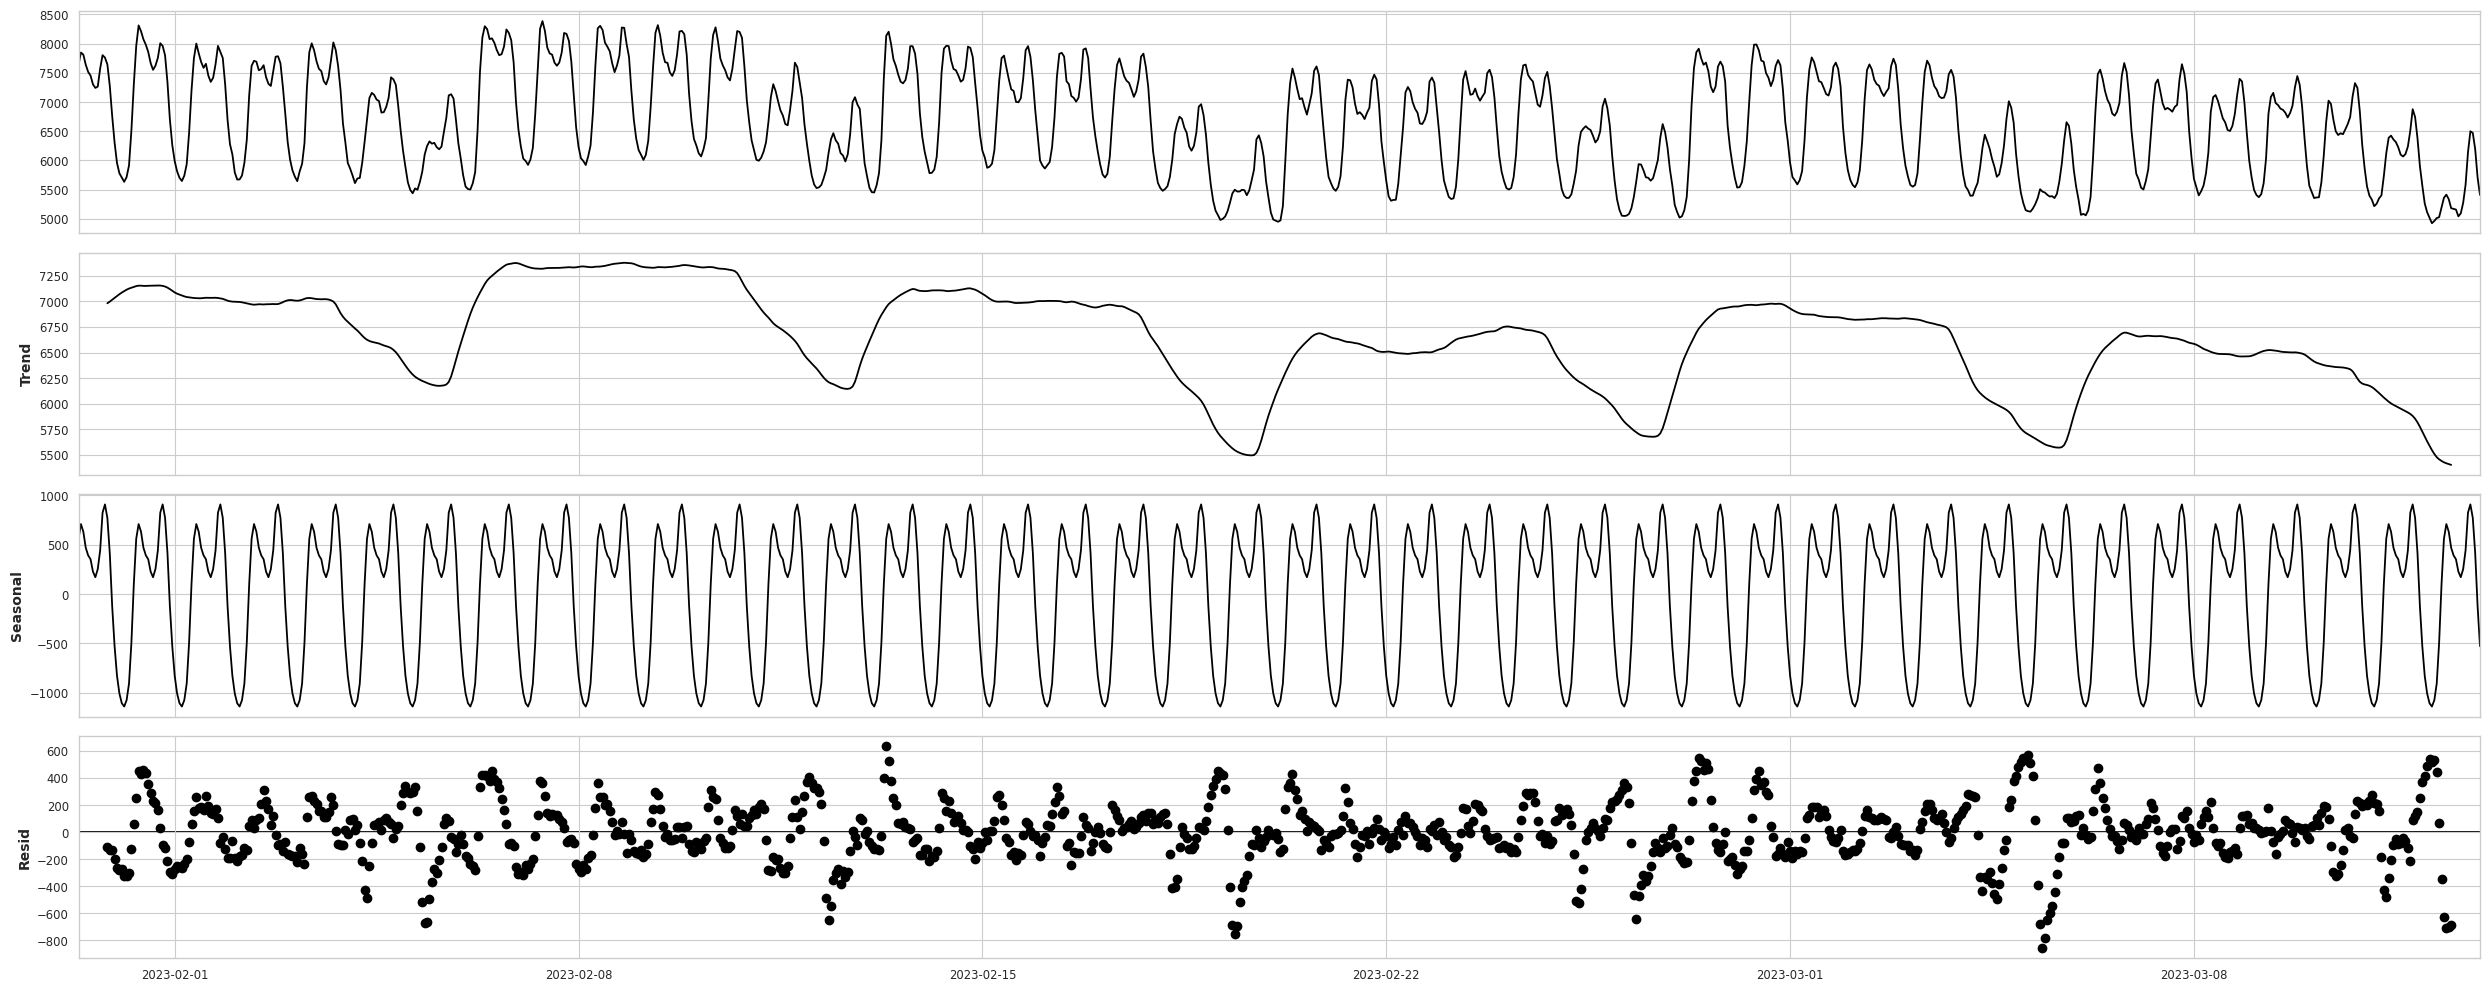

2024-01-26 07:27:53 [info     ] >> adf p-value: 3.425121590696174e-26
2024-01-26 07:27:53 [info     ] >> kpss p-value: 0.01
2024-01-26 07:27:53 [info     ] >> is stationary: True
2024-01-26 07:27:53 [info     ] >> plot of rolling mean and std


/home/mnpr/Workspace/Opencampus/TimeSeriesAnalysis/src/components/utils.py:74: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(ts_series, regression="c")


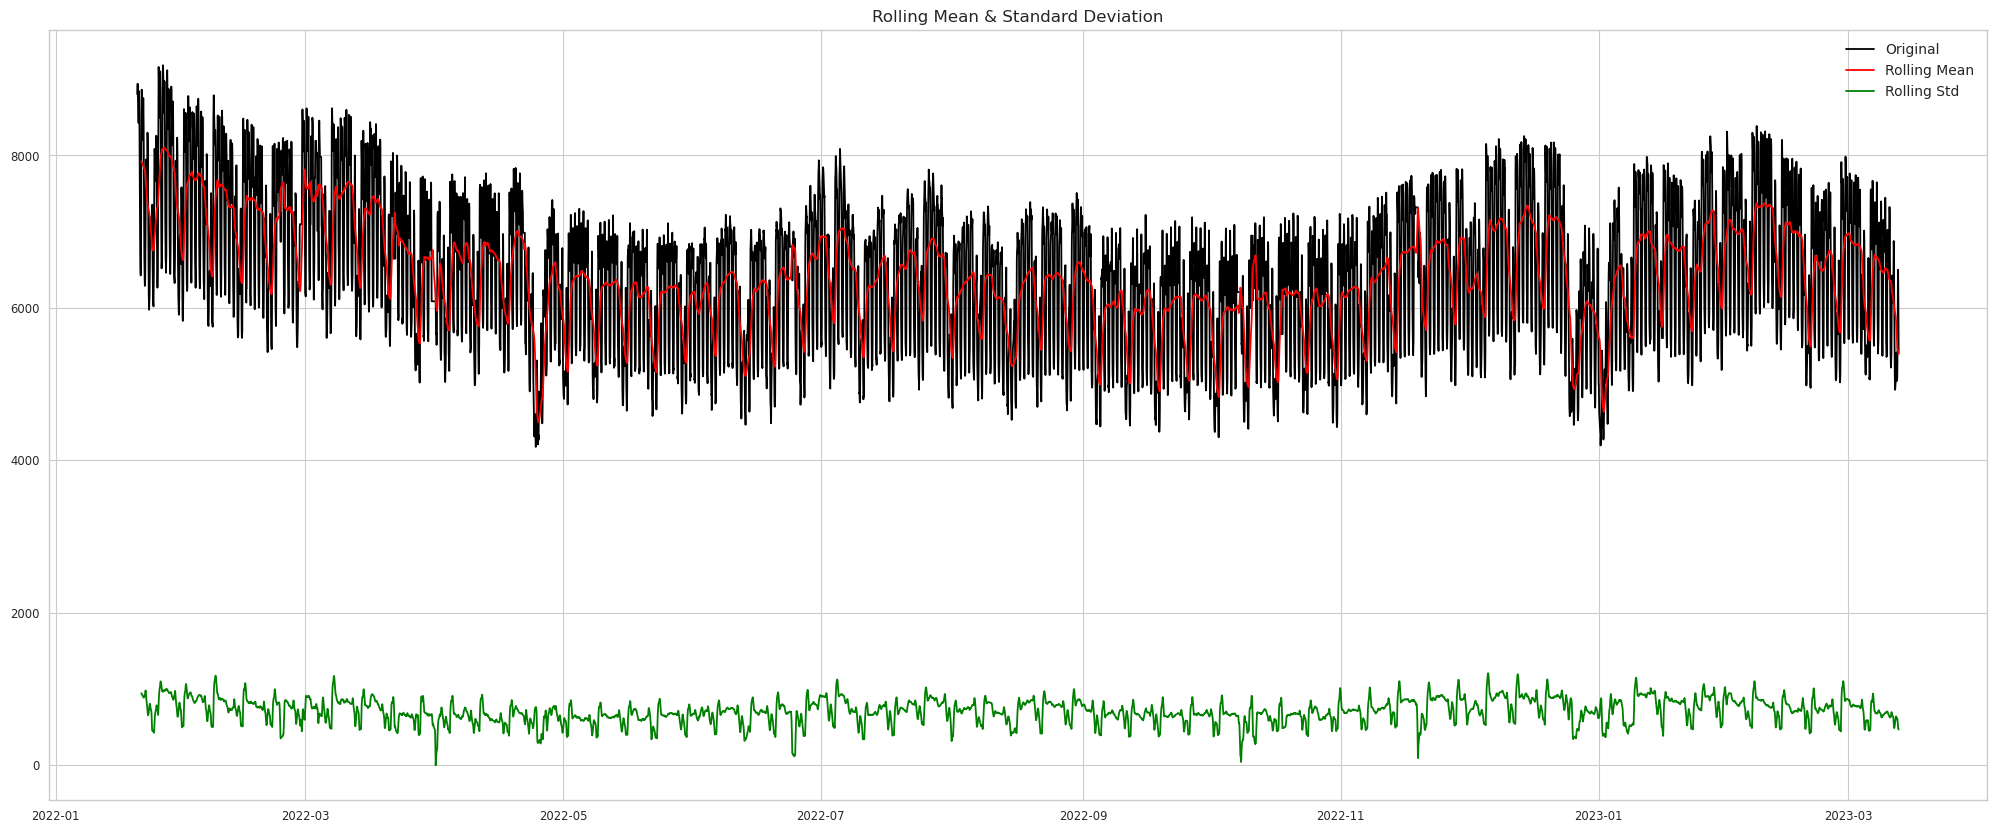

In [4]:
import statsmodels.api as sm

from components.utils import (
    adf_test,
    kpss_test
)

decomposition = sm.tsa.seasonal_decompose(df_load.iloc[-1000:], model='additive', period=24)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

logger.info(">> decomposition plot of trend, seasonality,and residual")
decomposition.plot()
plt.show()

def is_stationary(ts_series: pd.Series) -> bool:
    p_adf = adf_test(ts_series)["p-value"]
    logger.info(">> adf p-value: {}".format(p_adf))
    p_kpss = kpss_test(ts_series)["p-value"]
    logger.info(">> kpss p-value: {}".format(p_kpss))
    return (p_adf < 0.05) or (p_kpss > 0.05)

logger.info(">> is stationary: {}".format(is_stationary(df_load)))
logger.info(">> plot of rolling mean and std")

plt.plot(df_load.iloc[-10000:], label='Original')
plt.plot(df_load.iloc[-10000:].rolling(window=24).mean(), color='red', label='Rolling Mean') #daily rolling avg
plt.plot(df_load.iloc[-10000:].rolling(window=24).std(), color='green', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

### Correlations

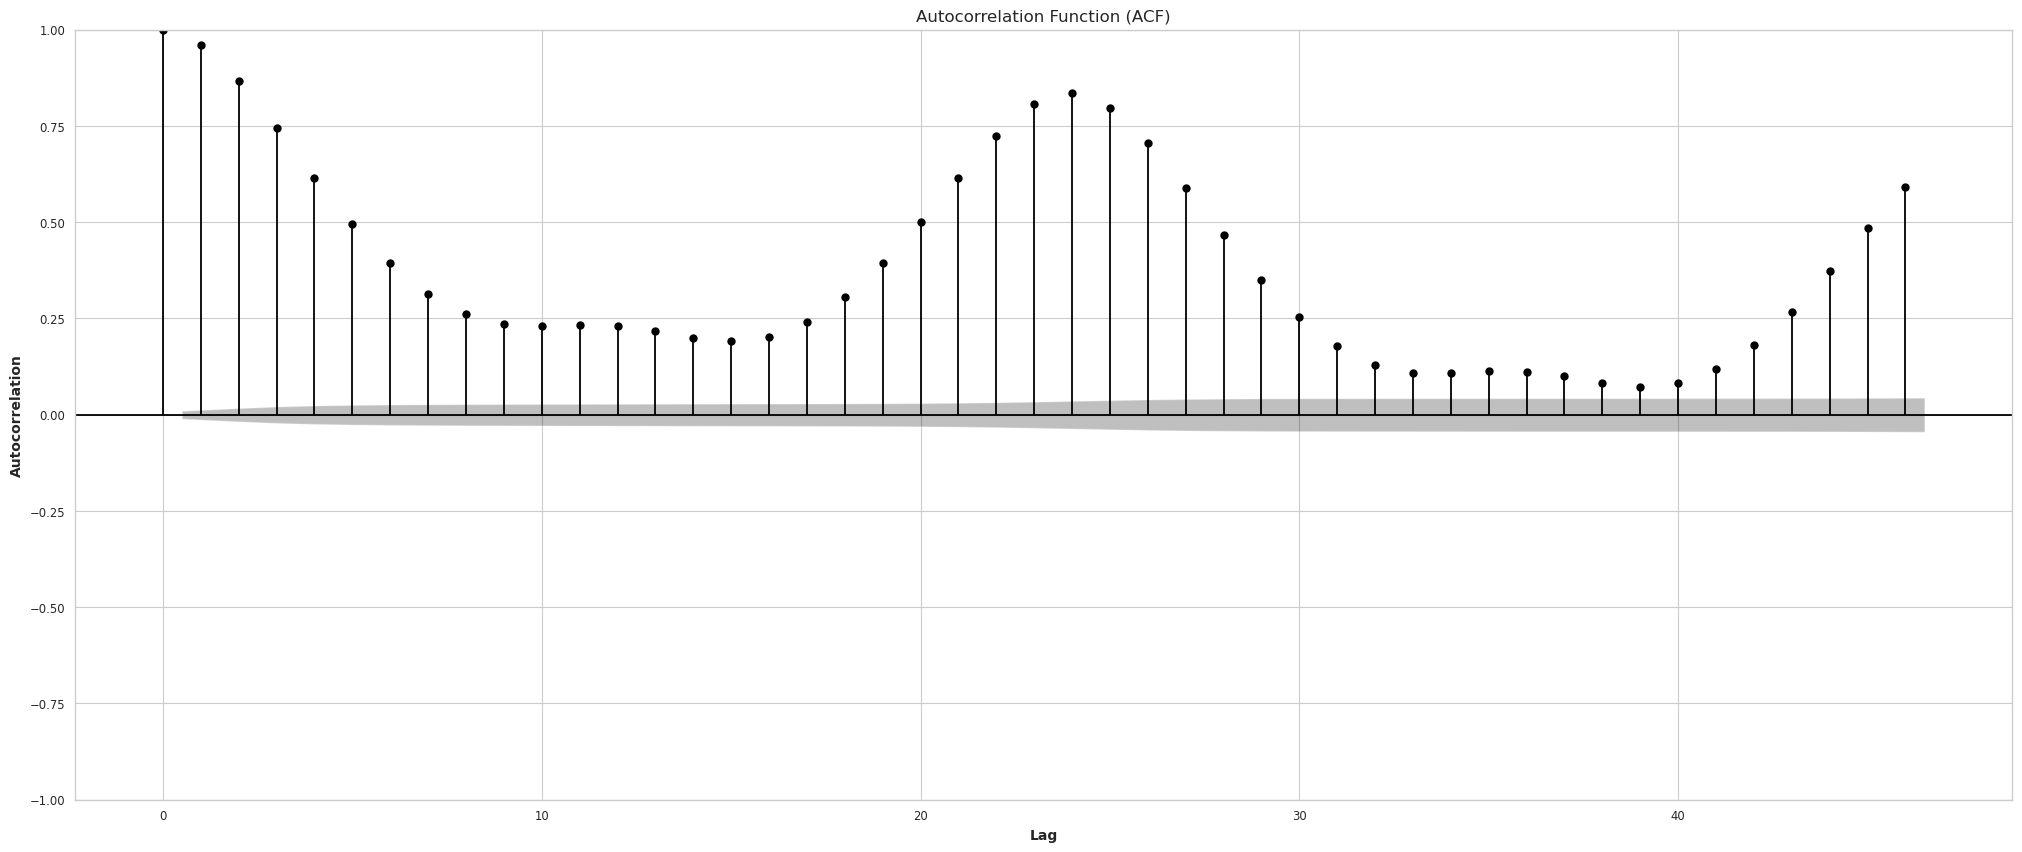

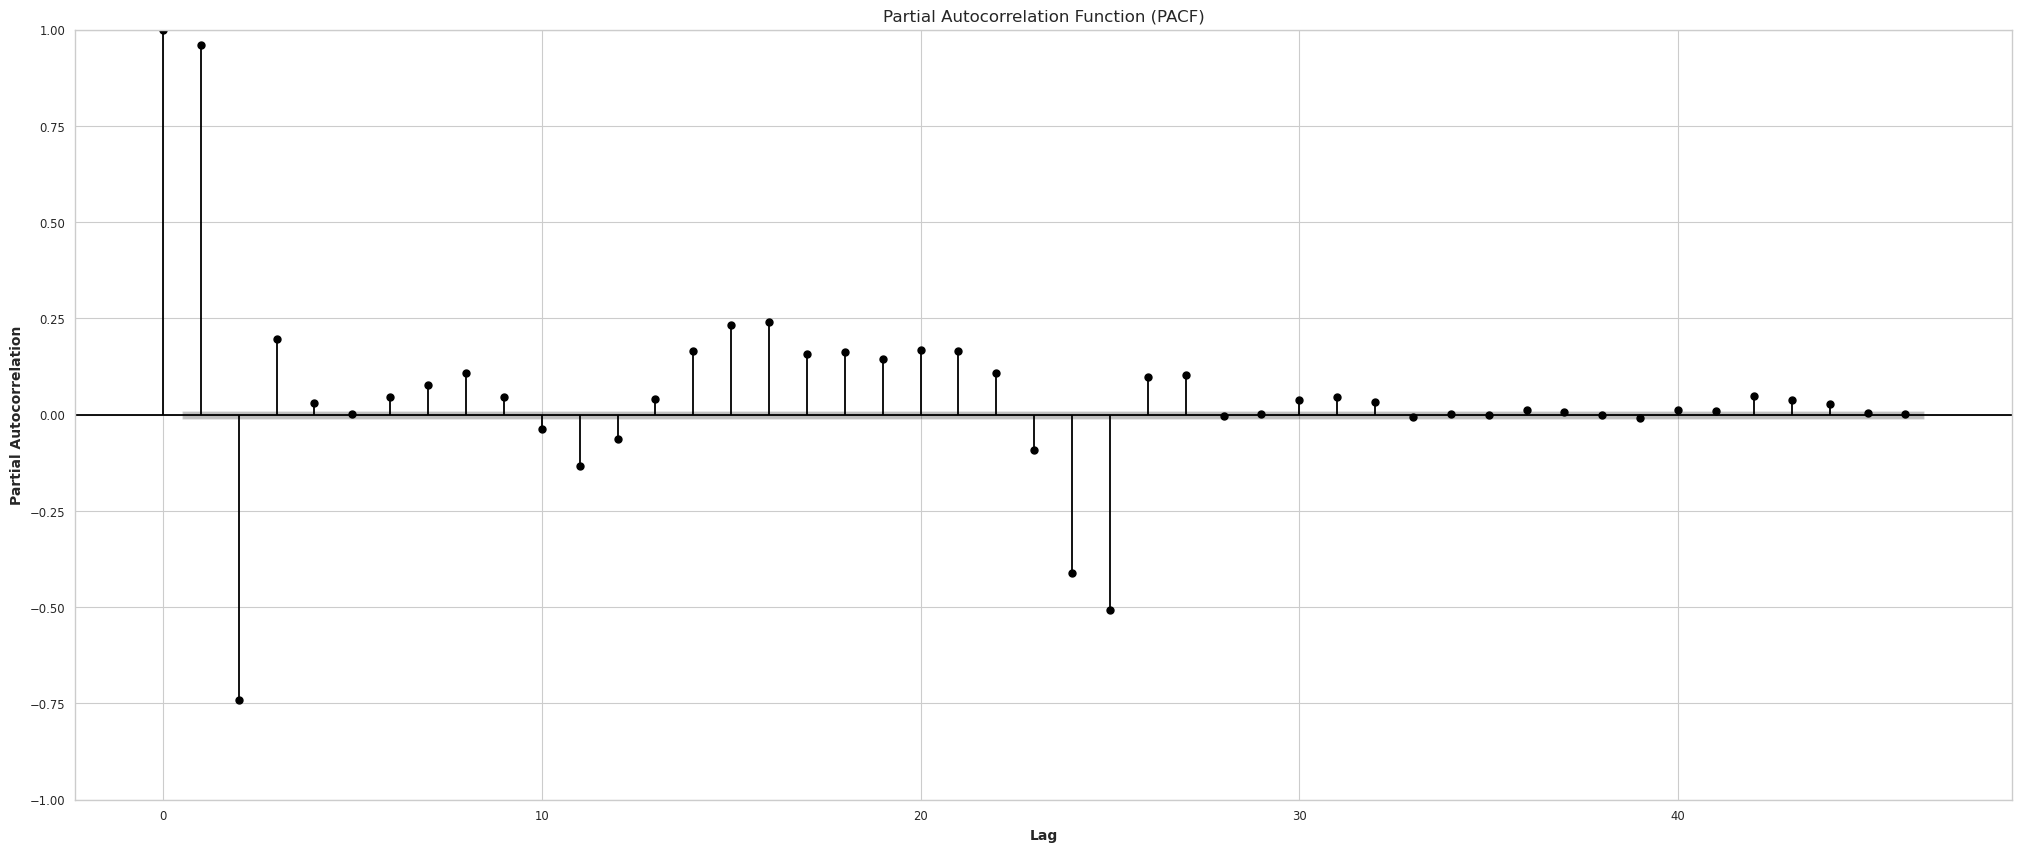

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF
fig, ax = plt.subplots()
plot_acf(df_load, ax=ax)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF)')
plt.show()

# PACF
fig, ax = plt.subplots()
plot_pacf(df_load, ax=ax)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

## 2. Modeling

- ARIMA
- Seasonal ARIMA
- Darts

In [6]:
daily_consumption = df_load.copy()

In [7]:
df_train, df_test = daily_consumption[:-24*7*2], daily_consumption[-24*7*2:]
logger.info(">> train set: {}, test set: {}".format(len(df_train), len(df_test)))

2024-01-26 07:27:59 [info     ] >> train set: 36432, test set: 336


In [8]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

import pmdarima as pma

from darts.models import (
    NaiveSeasonal
    , ExponentialSmoothing
)
from darts.utils.utils import ModelMode, SeasonalityMode
from darts.metrics import mape
from tqdm.autonotebook import tqdm

In [9]:
# Define SARIMA parameters
p, d, q = 1, 1, 1
P, D, Q, s = 1, 1, 1, 24  # Assuming daily seasonality

model = SARIMAX(df_train, order=(p, d, q), seasonal_order=(P, D, Q, s))
results = model.fit(disp=False)

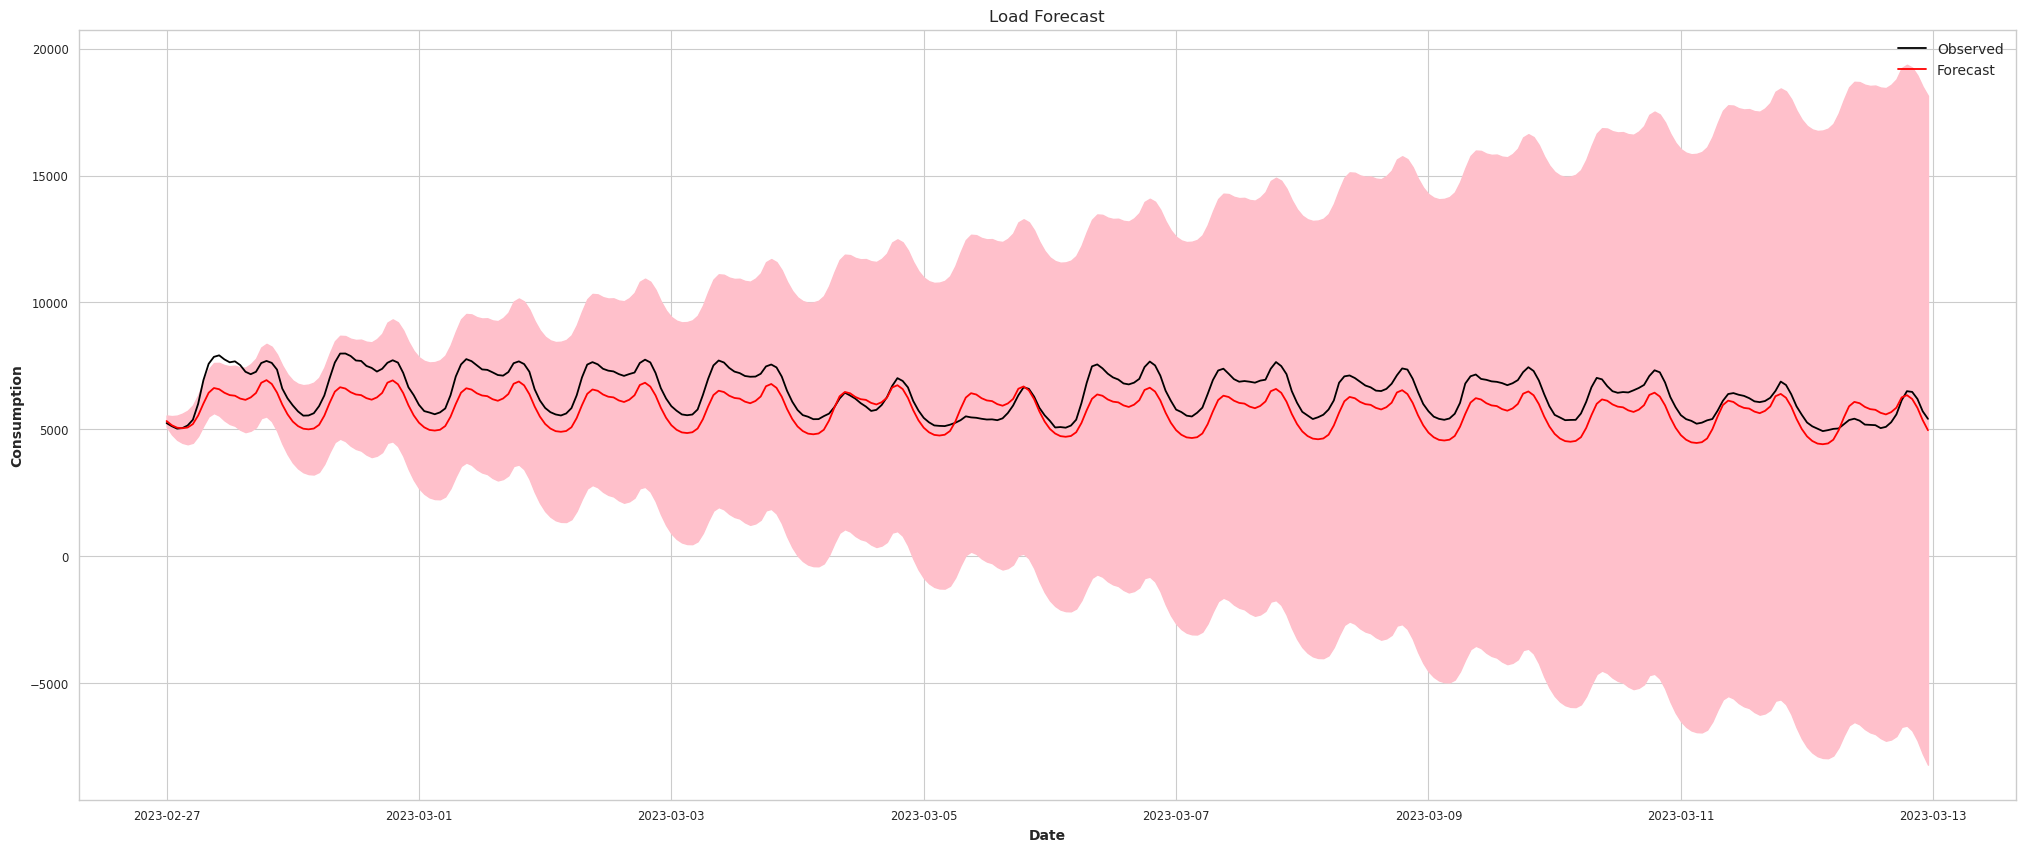

In [10]:
forecast_periods = len(df_test)
forecast = results.get_forecast(steps=forecast_periods)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

plt.figure()
plt.plot(df_test, label='Observed')
plt.plot(forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink')
plt.title("Load Forecast")
plt.xlabel("Date")
plt.ylabel("Consumption")
plt.legend()
plt.show()

In [11]:
from components.utils import get_error_metrics

error_metrics = get_error_metrics(df_test, forecast_mean)
print(error_metrics)

{'MSE': 648115.2970803566, 'RMSE': 805.0560831894612, 'MAE': 741.522453099189, 'MAPE': 0.1137155287898419, 'R2': 0.08333959709754724}


```python
#grid search
# sarima model is defined by p, d, q, P, D, Q, m (7 params)
# d = 1, m = 24

# optimal model with grid search

# fitting SARIMA with parameters combination for training and compare evaluation metrics
# Comparing AIC : balance of model complexity and goodness of fit, lower value indicate balanced accuracy and simplicity
import itertools
import math

# range of values for p, d, q, P, D, Q, and m
p_values = range(0, 3)  # Autoregressive order
d_values = [1]          # Differencing order
q_values = range(0, 3)  # Moving average order
P_values = range(0, 2)  # Seasonal autoregressive order
D_values = range(0, 1)  # Seasonal differencing order
Q_values = range(0, 2)  # Seasonal moving average order
m_values = [24]         # Seasonal period

param_combinations = list(itertools.product(
    p_values,
    d_values,
    q_values,
    P_values,
    D_values,
    Q_values,
    m_values
))

best_aic = float("inf")
best_params = None

for params in param_combinations:
    order = params[:3]
    seasonal_order = params[3:]

    try:
        model = sm.tsa.SARIMAX(
            df_train, order=order, seasonal_order=seasonal_order
        )
        result = model.fit(disp=False)
        aic = result.aic
        # Ensure the convergence of the model
        if not math.isinf(result.zvalues.mean()):
            logger.info("order: {}, seasonal_order: {}, AIC: {}".format(order, seasonal_order, aic))
            if aic < best_aic:
                best_aic = aic
                best_params = params
        else:
            print(order, seasonal_order, 'not converged')
    except:
        continue
print("Best Parameters:", best_params)
print("Best AIC:", best_aic)
```

In [12]:
# p, d, q, P, D, Q, m
best_params = [2, 1, 2, 1, 0, 1, 24]

model = SARIMAX(
    df_train,
    enforce_stationarity=False,
    order=best_params[:3],
    seasonal_order=best_params[3:]
)
results = model.fit(disp=False)

/home/mnpr/miniforge3/envs/timeseries/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


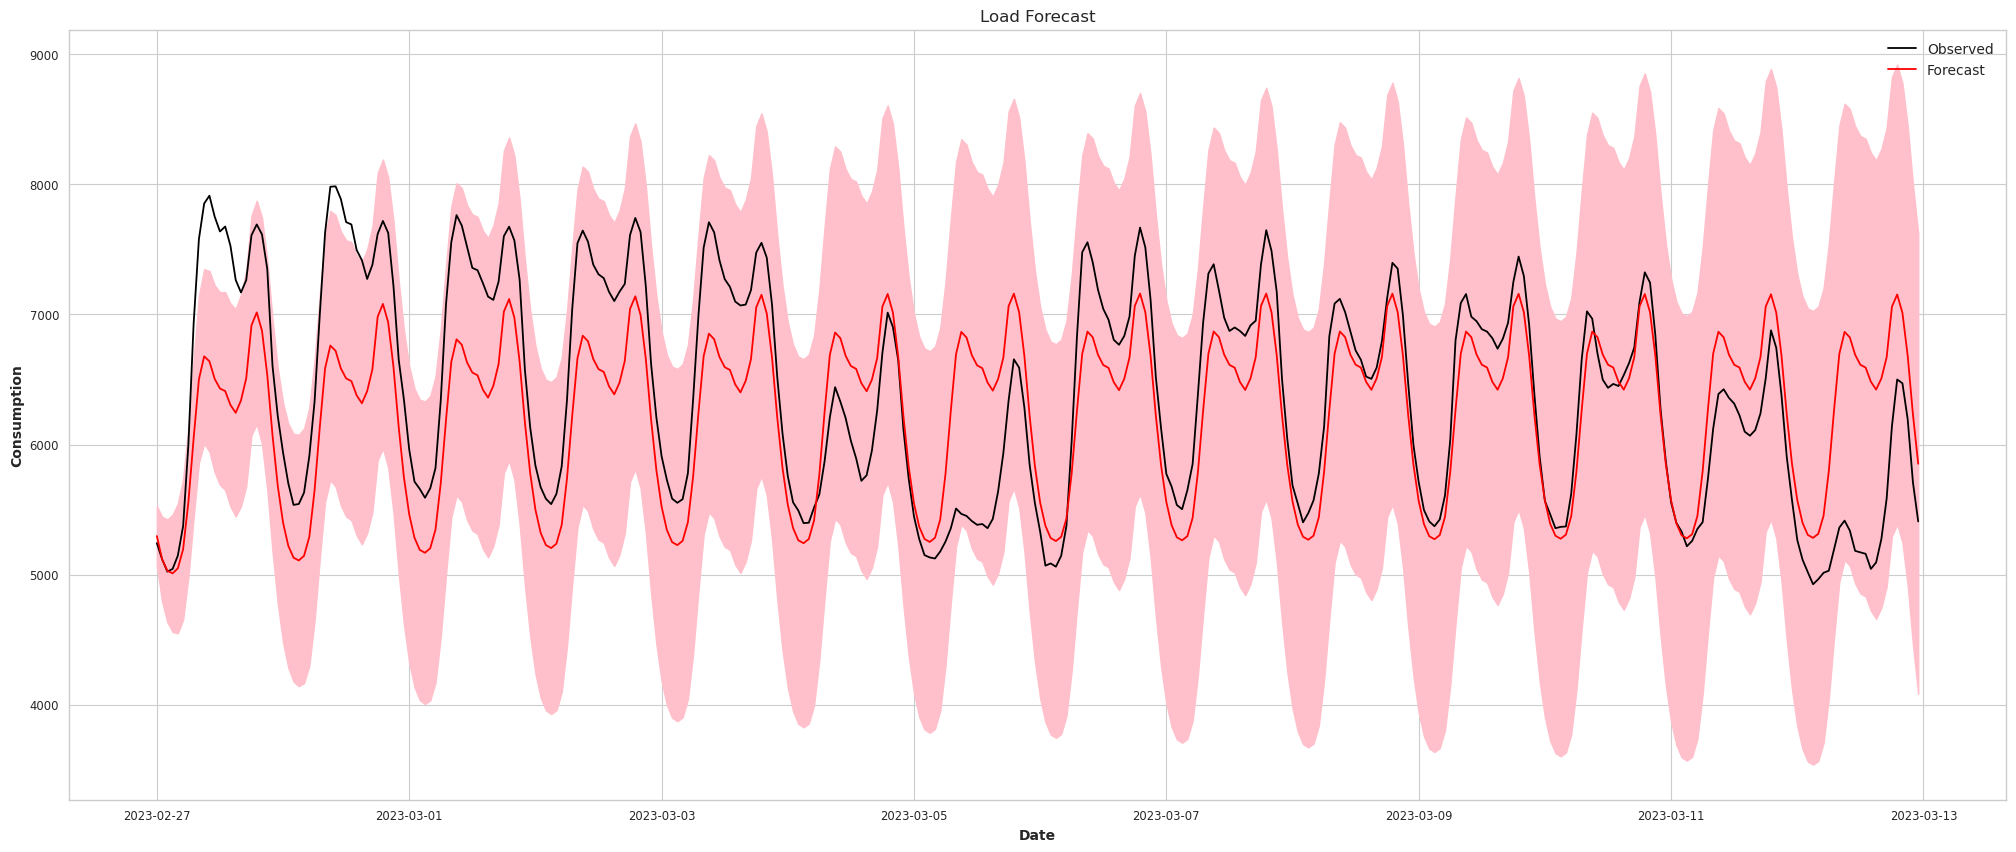

In [13]:
forecast_periods = len(df_test) # 7 days
forecast = results.get_forecast(steps=forecast_periods)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

plt.figure()
plt.plot(df_test, label='Observed')
plt.plot(forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink')
plt.title("Load Forecast")
plt.xlabel("Date")
plt.ylabel("Consumption")
plt.legend()
plt.show()

In [14]:
error_metrics = get_error_metrics(df_test, forecast_mean)
print(error_metrics)

{'MSE': 354765.17060848634, 'RMSE': 595.621667343026, 'MAE': 485.21629265783884, 'MAPE': 0.0753266949299427, 'R2': 0.4982386842422998}


### Auto ARIMA

In [15]:
import pmdarima as pma

def get_forecast (df_test, model):
    fitted, confint = arima_model.predict(n_periods=len(df_test), return_conf_int=True)

    fitted_series = pd.Series(fitted, index=df_test.index)
    lower_series = pd.Series(confint[:, 0], index=df_test.index)
    upper_series = pd.Series(confint[:, 1], index=df_test.index)

    plt.plot(df_test)
    plt.plot(fitted, color='red')
    plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)

    plt.title("ARIMA/SARIMA - Load Consumption Forecast")
    plt.show()

In [16]:
arima_model = pma.auto_arima(
    df_train
    , start_p=1
    , start_q=1
    , test='adf'
    , max_p=3
    , max_q=3
    , m=1
    , d=None
    , seasonal=False
    , error_action='warn' #shows errors ('ignore' silences these)
    , suppress_warnings=True
    , stepwise=True
)
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                36432
Model:               SARIMAX(3, 0, 2)   Log Likelihood             -241980.511
Date:                Fri, 26 Jan 2024   AIC                         483973.022
Time:                        07:34:45   BIC                         484024.041
Sample:                    01-01-2019   HQIC                        483989.242
                         - 02-26-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.5819      0.005    499.941      0.000       2.572       2.592
ar.L2         -2.2708      0.010   -225.158      0.000      -2.291      -2.251
ar.L3          0.6889      0.005    136.466      0.000       0.679       0.699
ma.L1         -0.8089      0.006   -126.192      0.000      -0.821      -0.796
ma.L2         -0.1749      0.006    -27.111      0.000      -0.188      -0.162
sigma2      3.442e+04   4.27e-08   8.06e+11      0.000    3.44e+04    3.44e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.37   Jarque-Bera (JB):              5985.59
Prob(Q):                              0.54   Prob(JB):                         0.00
Heteroskedasticity (H):               0.87   Skew:                             0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.95e+26. Standard errors may be unstable.
"""

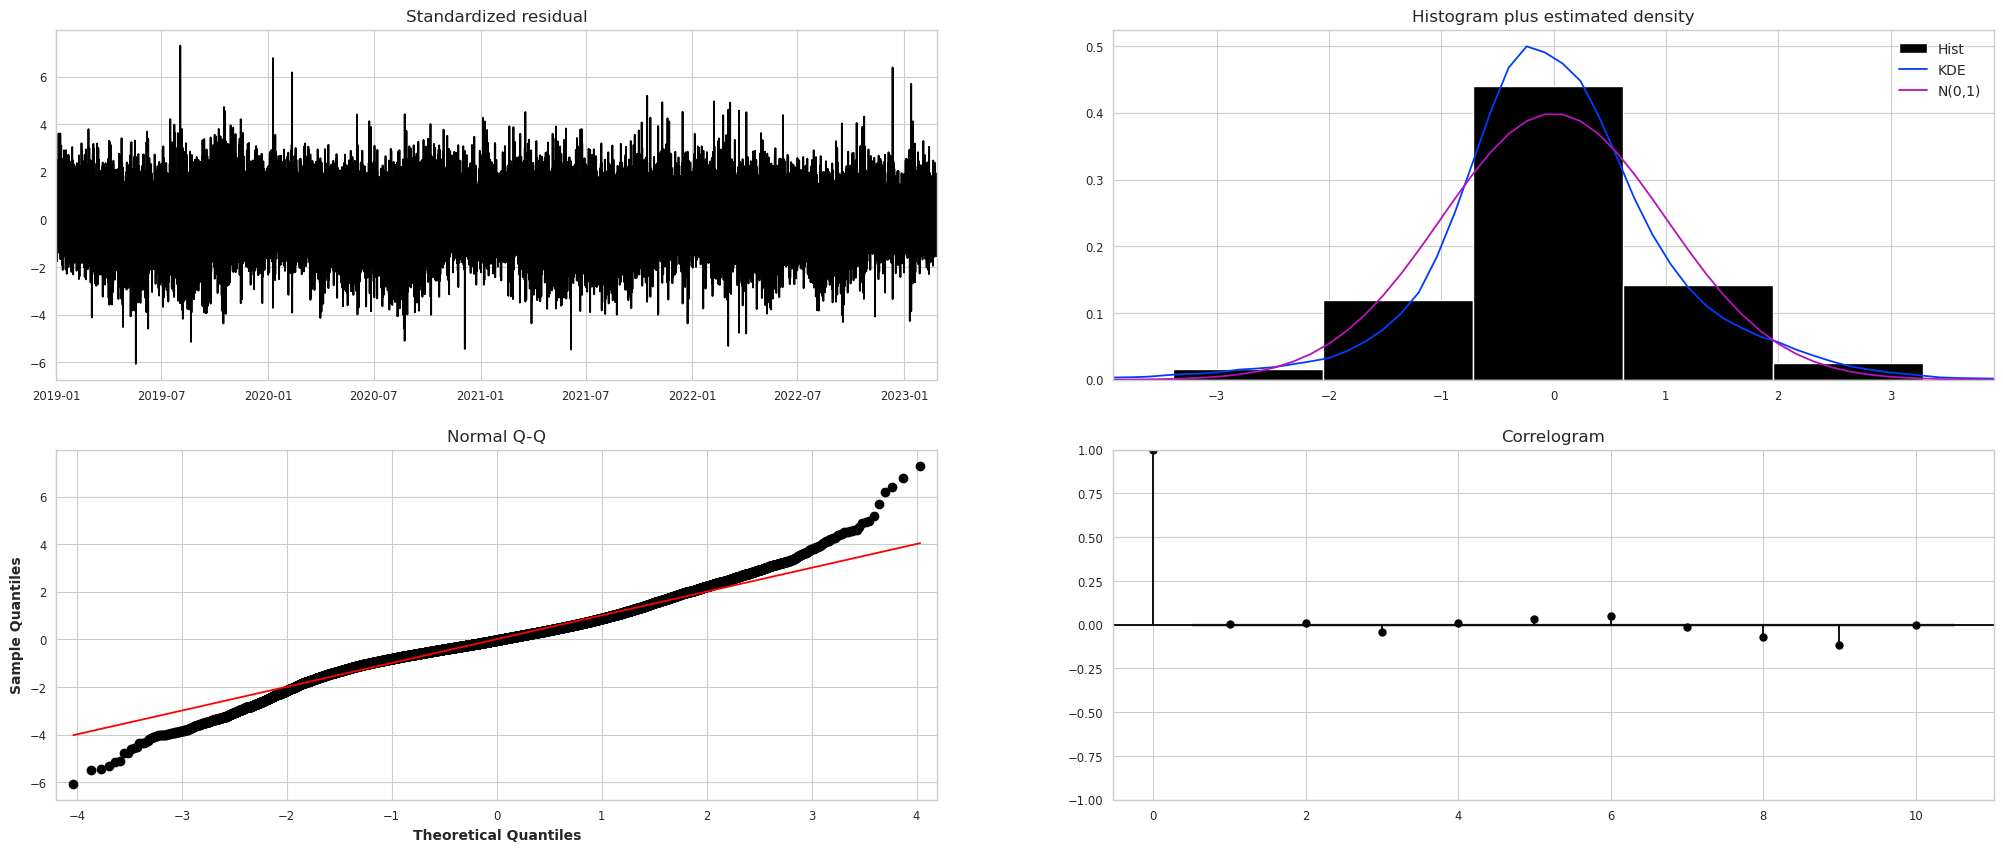

In [17]:
arima_model.plot_diagnostics()
plt.show()

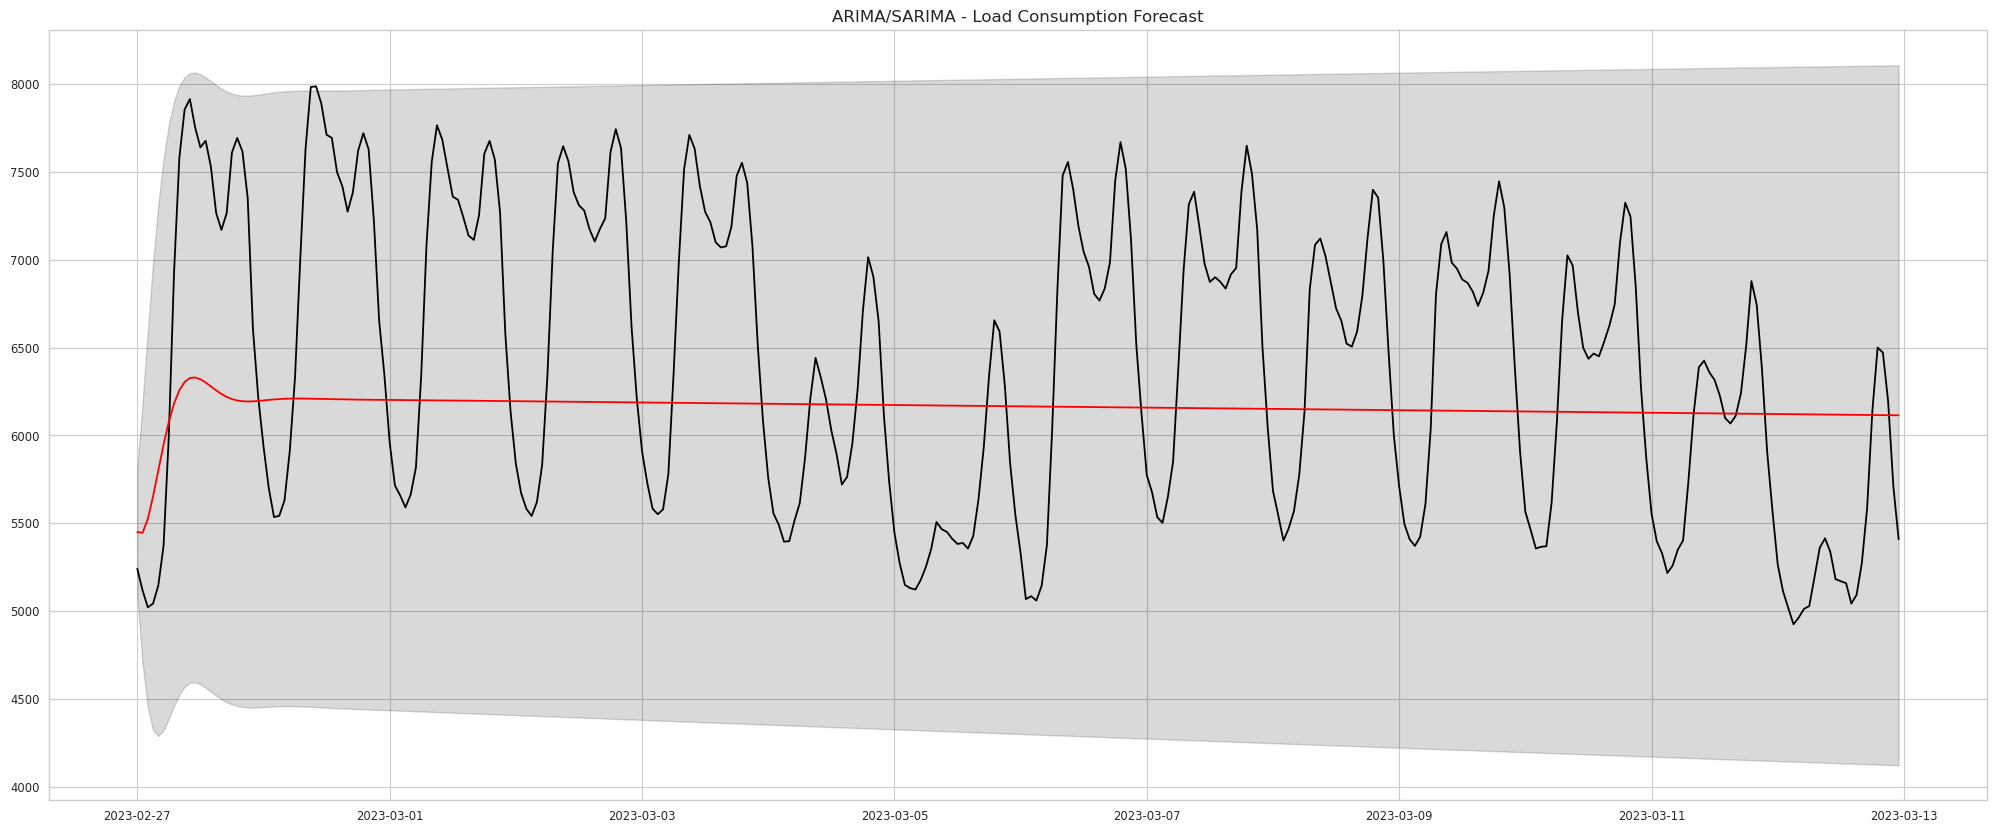

In [18]:
get_forecast(df_test, arima_model)

### SARIMA

```python
import pmdarima as pma

sarima_model = pma.auto_arima(
    df_train
    , start_p=1
    , start_q=1
    , test='adf'
    , max_p=3
    , max_q=3
    , m=24
    , start_P=0
    , seasonal=True
    , d=None
    , D=1
    , trace=False
    , error_action='warn' #shows errors ('ignore' silences these)
    , suppress_warnings=True
    , stepwise=True
)
sarima_model.summary()

logger.info("plotting diagnostics")
sarima_model.plot_diagnostics()
plt.show()

get_forecast(df_test, sarima_model)
```

### Darts

2024-01-26 07:35:51 [info     ] >> train set: 36096, valid set: 672


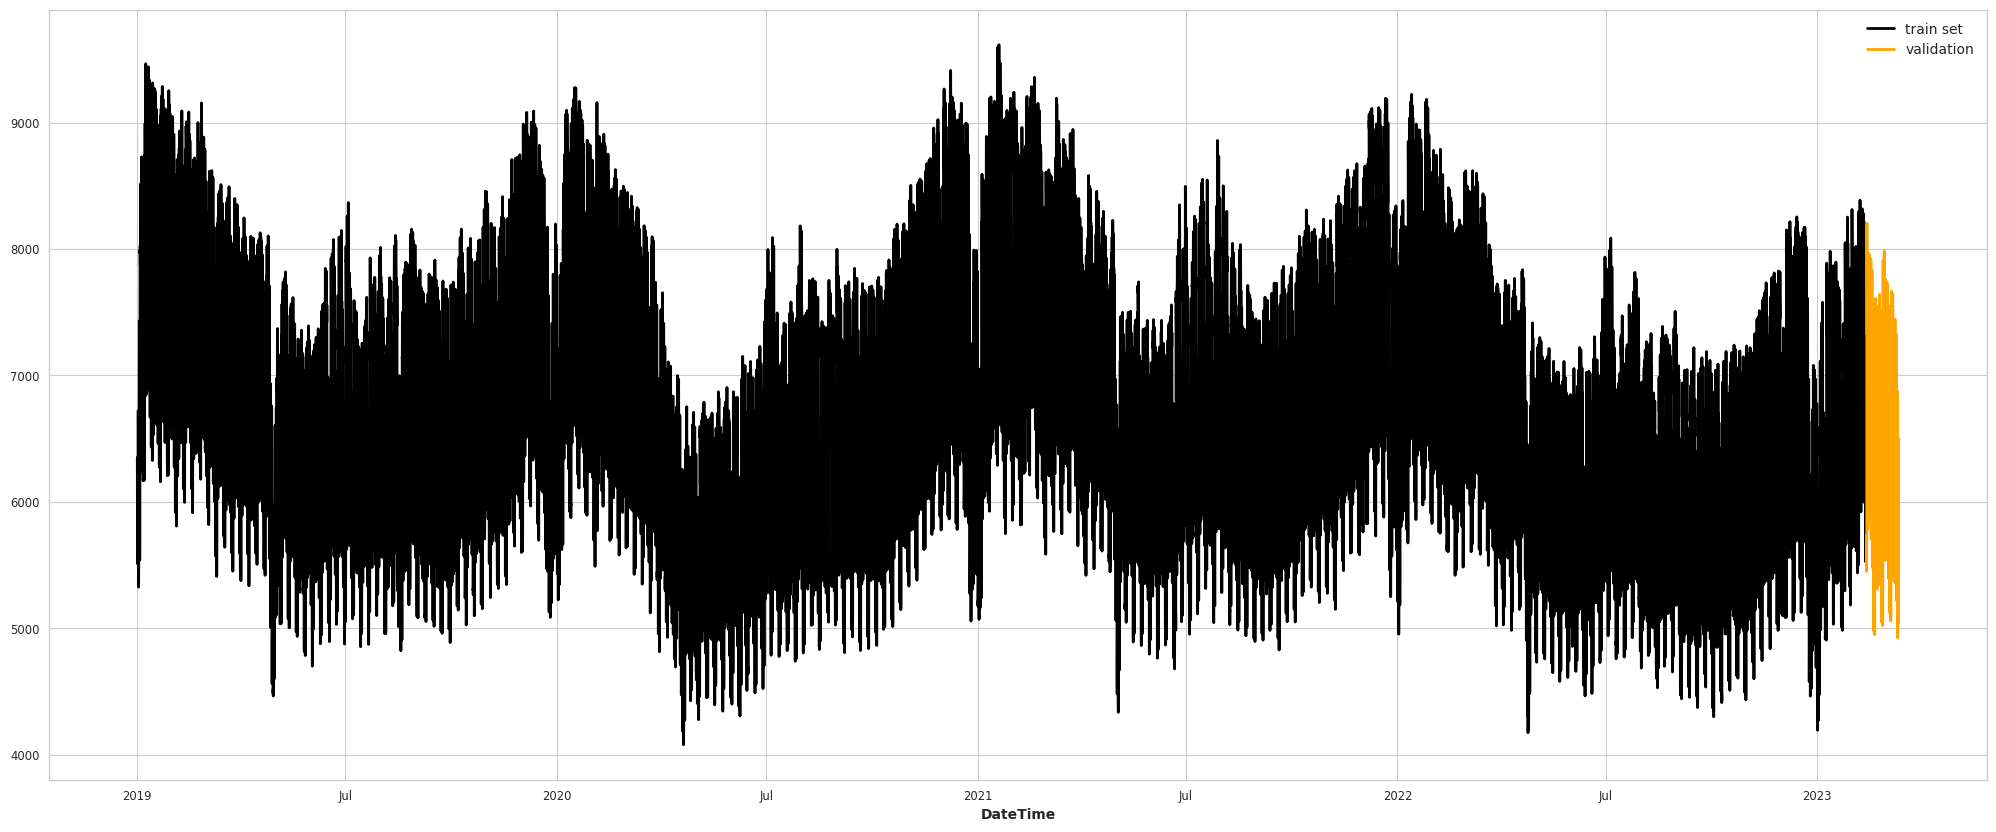

In [20]:
data_series = TimeSeries.from_dataframe(df_load)

train_set, valid_set = data_series[:-24*7*4], data_series[-24*7*4:] # 4 weeks
logger.info(">> train set: {}, valid set: {}".format(len(train_set), len(valid_set)))

train_set.plot(label='train set')
valid_set.plot(label='validation', color='orange')
plt.show()

2024-01-26 07:35:52 [info     ] >> fit NaiveSeasonal model
2024-01-26 07:35:52 [info     ] >> predict with valid set
2024-01-26 07:35:52 [info     ] >> Mean average percentage error: 8.591315592533743


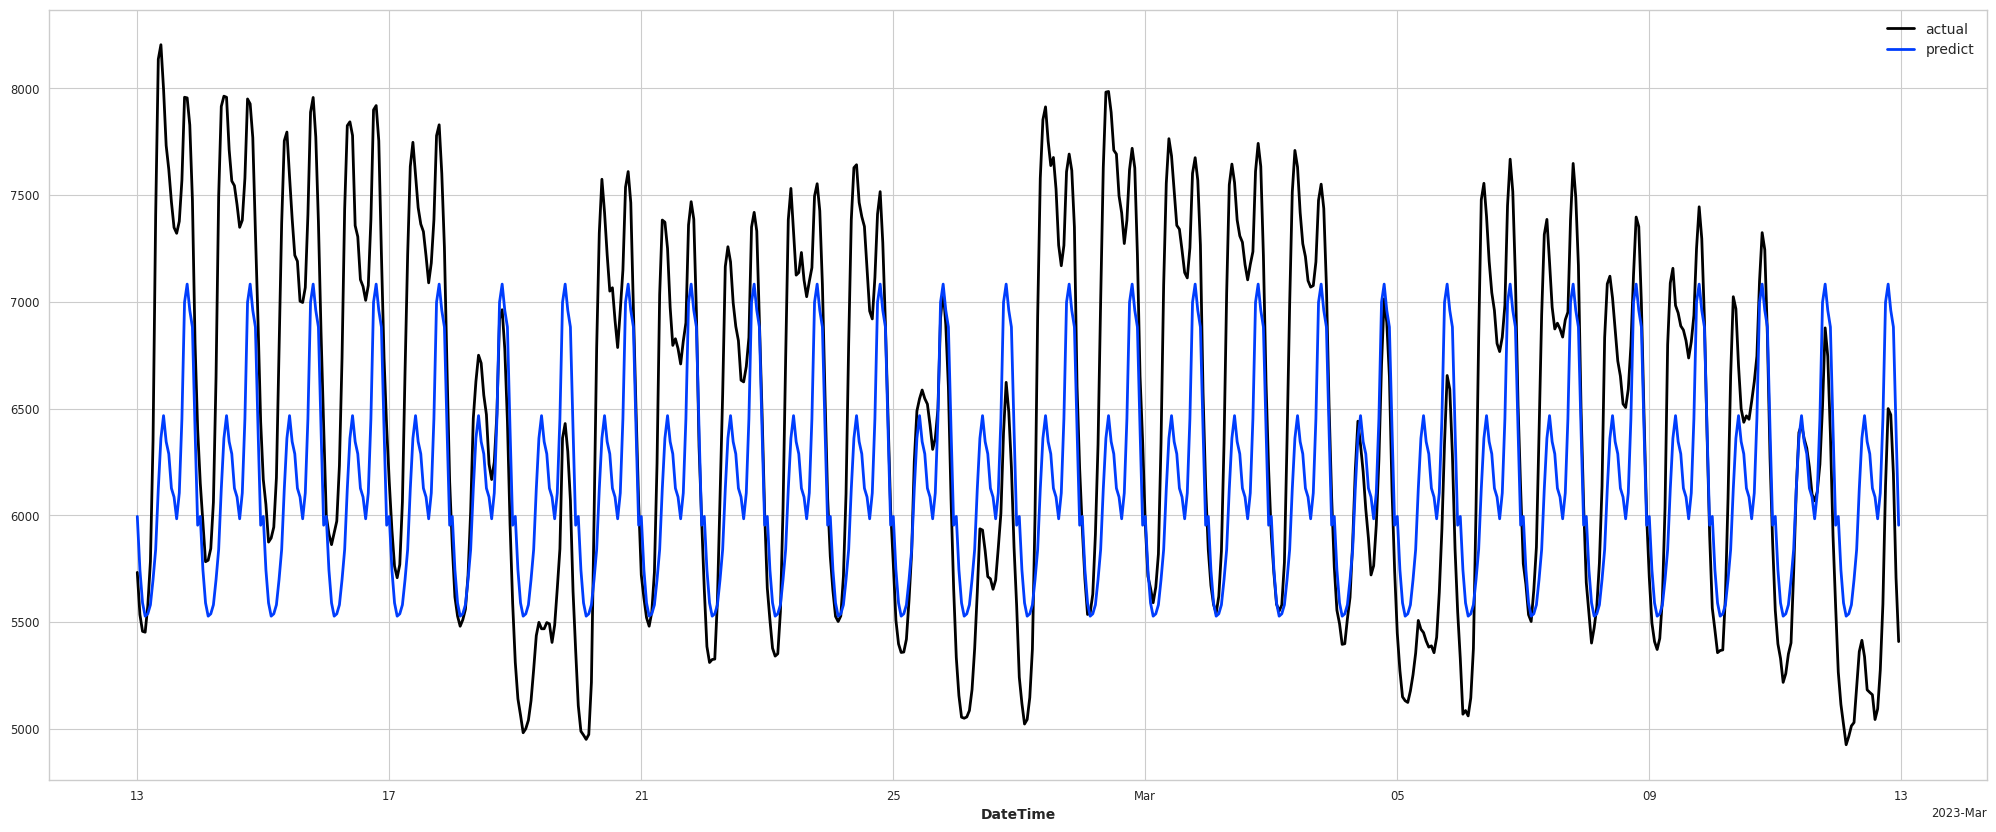

In [21]:
load_model = NaiveSeasonal(K=24) #daily seasonality
load_model.fit(train_set)
logger.info(">> fit NaiveSeasonal model")

prediction = load_model.predict(len(valid_set))
logger.info(">> predict with valid set")

valid_set.plot(label='actual')
prediction.plot(label='predict', low_quantile=0.05, high_quantile=0.95)
plt.legend()


logger.info(">> Mean average percentage error: {}".format(mape(valid_set, prediction)))

/home/mnpr/miniforge3/envs/timeseries/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


2024-01-26 07:36:06 [info     ] >> fit NaiveSeasonal model
2024-01-26 07:36:06 [info     ] >> predict with valid set
2024-01-26 07:36:06 [info     ] >> Mean average percentage error: 6.725863060811957


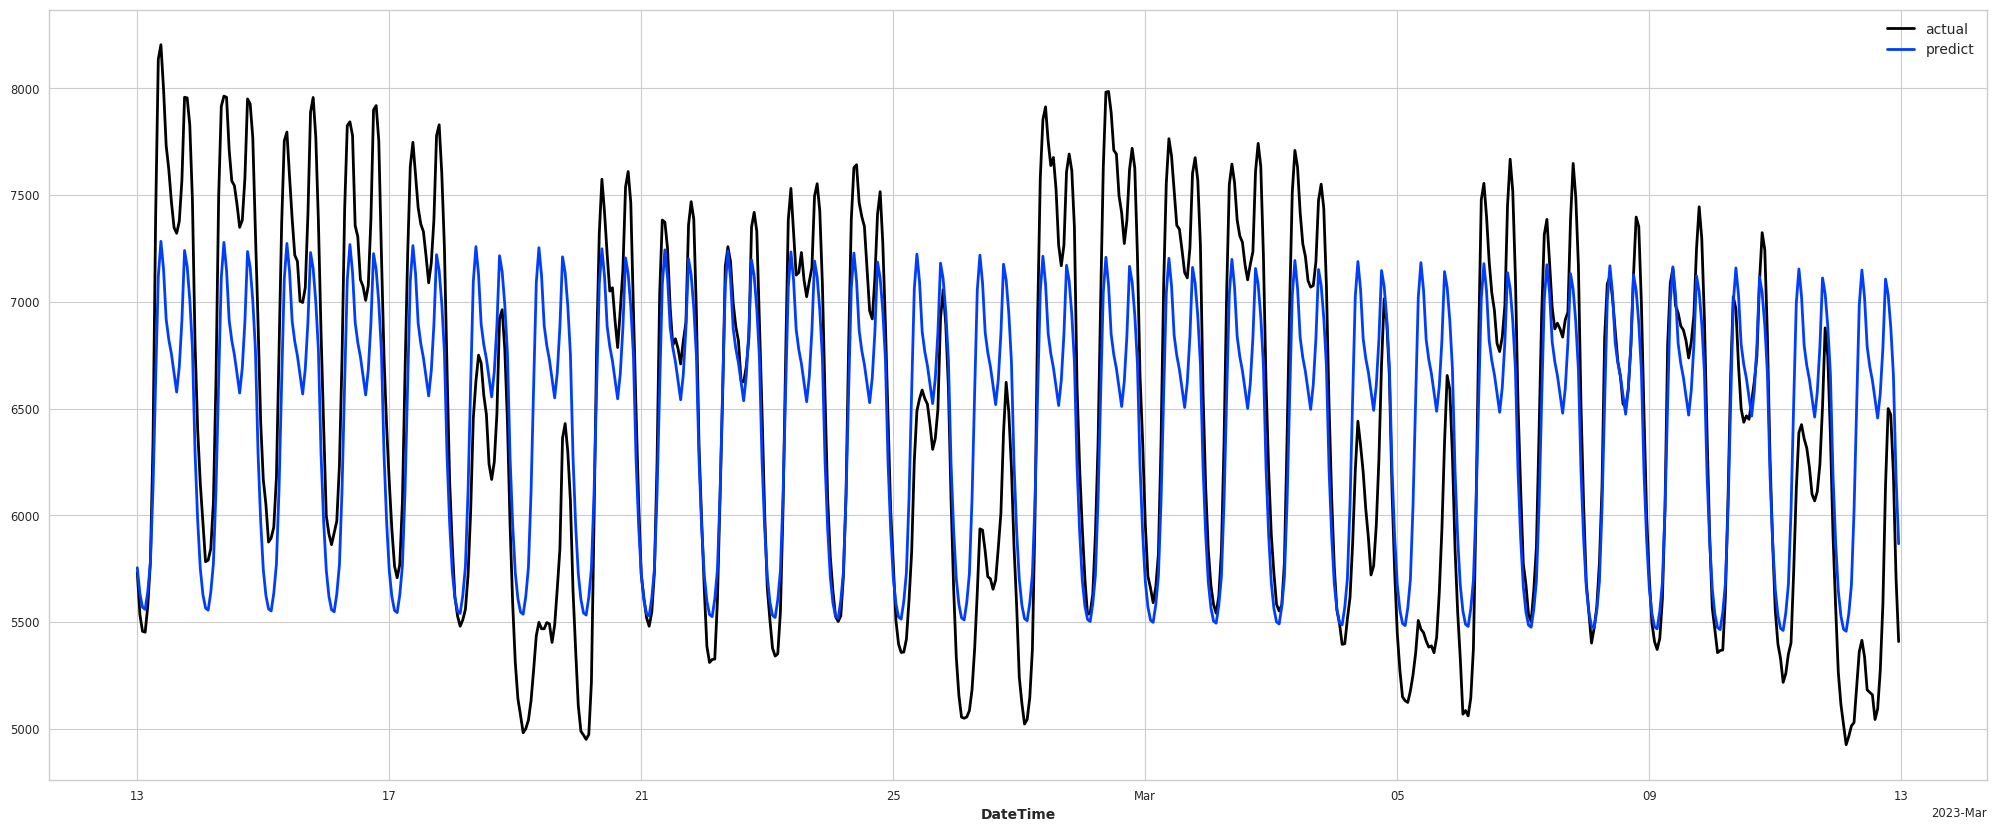

In [22]:
#holz winter
load_model = ExponentialSmoothing(
    trend=ModelMode.ADDITIVE,
    seasonal=SeasonalityMode.MULTIPLICATIVE
)
load_model.fit(train_set)
logger.info(">> fit NaiveSeasonal model")

prediction = load_model.predict(len(valid_set))
logger.info(">> predict with valid set")

valid_set.plot(label='actual')
prediction.plot(label='predict', low_quantile=0.05, high_quantile=0.95)
plt.legend()

logger.info(">> Mean average percentage error: {}".format(mape(valid_set, prediction)))

## 3. Evaluation


|Models|MAPE|
|-|-|
|SARIMA(Grid Search)|0.1137155287898419|
|Naive Seasonal(daily)|8.591315592533743|
|ES(holz winter)|8.591315592533743|

___